<a href="https://colab.research.google.com/github/Whiner123/sber_jun_test/blob/main/sber_jun_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymorphy3


import pandas as pd
import pymorphy3
import navec
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
ru_stopwords = stopwords.words("russian")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from gensim import corpora
from gensim.models import TfidfModel
from gensim.parsing.preprocessing import preprocess_string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_s = pd.read_csv('/content/drive/MyDrive/parsed_reviews3.csv')
df_s

,body,title,rating,bank_name,date
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36
...,...,...,...,...,...
92730,"30 августа обнаружила, что баланс уменьшился. ...",Банк списал деньги и теперь рекомендует их сам...,1,Совкомбанк,2022-09-02 11:47:44
92731,Обратился с вопросом (6908609) по All Airlines...,Отличная консультация от сотрудника поддержки,5,Тинькофф Банк,2022-09-02 11:46:24
92732,В августе 2021 я досрочно погасил ипотеку (кре...,Снятие обременения с квартиры,2,Россельхозбанк,2022-09-02 11:34:34
92733,9.08.22 оформлен кредит на покупку автомобиля ...,Штрафные санкции,1,Драйв Клик Банк,2022-09-02 11:28:32


In [ ]:
def color_cells(val):
    """ val: значение признака """

    if val == 'float64':
        color = 'red'
    elif val == 'int64':
        color = 'red'
    else:
        color = 'blue'
    return f'color: {color}'
info = pd.DataFrame()
info.index = df_s.columns
info['Тип данных'] = df_s.dtypes
info['Количесвто уникальных'] = df_s.nunique()
info['Количество пропусков'] = df_s.isna().sum()
info['Количество значений'] = df_s.count()
info['%значений'] = round((df_s.count()/ df_s.shape[0]) * 100,2)
info = info.style.applymap(color_cells, subset=['Тип данных'])
info

,Тип данных,Количесвто уникальных,Количество пропусков,Количество значений,%значений
body,object,91832,0,92735,100.000000
title,object,54505,0,92735,100.000000
rating,int64,5,0,92735,100.000000
bank_name,object,157,0,92735,100.000000
date,object,91059,0,92735,100.000000


In [ ]:
print(f"количество дубликатов: {df_s.duplicated().sum()}")
df_s = df_s.drop_duplicates()
print("форма датасета после удаления дубликатов:", df_s.shape)

количество дубликатов: 62
форма датасета после удаления дубликатов: (92673, 5)


In [ ]:
top = df_s.groupby('bank_name').agg({'body':'count','rating':'mean'}).reset_index()
top = top.sort_values(by='body', ascending=False).head(15)
top['rating'] = top['rating'].round(2)
top

,bank_name,body,rating
135,Тинькофф Банк,44852,4.78
145,Хоум Кредит Банк,9301,4.51
126,Совкомбанк,6100,4.26
38,ВТБ,3814,1.95
123,СберБанк,3487,2.30
14,Альфа-Банк,3368,1.71
114,Россельхозбанк,3062,4.46
29,Банк Открытие,1894,3.54
76,МТС Банк,1542,2.90
81,Модульбанк,1452,4.78


In [ ]:
top.sort_values(by = 'rating',ascending = False).head(1)

,bank_name,body,rating
135,Тинькофф Банк,44852,4.78


In [ ]:
df_s['date'] = df_s['date'].astype('datetime64')
df_s['year'] = df_s['date'].dt.year
df_s['month'] = df_s['date'].dt.month
df_s['day'] = df_s['date'].dt.day

df_s


In [ ]:
df_s['year_month'] = df_s['year'].astype(str) + '-' + df_s['month'].astype(str)
data_to_graph = df_s[['bank_name','year_month','rating']]
data_to_graph = data_to_graph[data_to_graph['bank_name'].isin(top.head(5)['bank_name'])].groupby(['bank_name', 'year_month']).agg({'rating': 'mean'}).reset_index()
data_to_graph['rating'] = data_to_graph['rating'].round(2)


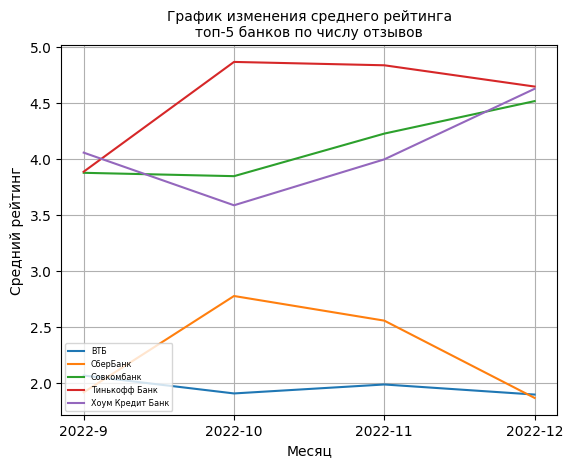

In [ ]:
order = ['2022-9', '2022-10', '2022-11', '2022-12','2023-1']

data_to_graph['year_month'] = pd.Categorical(data_to_graph['year_month'], categories=order, ordered=True)
data_to_graph = data_to_graph.sort_values(by=['bank_name', 'year_month']).reset_index(drop=True)
data_to_graph.head(10)
data_to_graph = data_to_graph[data_to_graph['year_month'] != '2023-1']
banks = data_to_graph['bank_name'].unique()
for b in banks:
    bank_data = data_to_graph[data_to_graph['bank_name'] == b]
    plt.plot(bank_data['year_month'], bank_data['rating'], label=b)
plt.title('График изменения среднего рейтинга\nтоп-5 банков по числу отзывов', fontsize=10)
plt.xlabel('Месяц')
plt.ylabel('Средний рейтинг')
plt.box(True)
plt.legend(fontsize='xx-small', loc='lower left')
plt.grid()
plt.show()

In [ ]:
def preprocess(df_s):
    cleaned_body = []
    morph = pymorphy3.MorphAnalyzer()
    clear = list(df_s['body'])
    for c in clear:
        soup = BeautifulSoup(c, 'html.parser')
        text = soup.get_text()
        text = BeautifulSoup(text)
        c = text.get_text()
        words = re.findall(r'\b[а-яА-Яa-zA-Z]+\b', c)
        processed_words = []
        for w in words:
            if w.isalpha() and len(w) > 1 and w not in ru_stopwords:
                w = w.strip()
                try:
                    w = morph.parse(w)[0].normal_form
                    processed_words.append(w)
                except:
                    processed_words.append(w)

        cleaned_body.append(' '.join(processed_words))
    df_s['cleaned_body'] = cleaned_body
    return df_s


In [ ]:
df_s = preprocess(df_s)

<ipython-input-72-47b8fc934fb6>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(c, 'html.parser')
<ipython-input-72-47b8fc934fb6>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_s['cleaned_body'] = cleaned_body


In [ ]:
df_s

,body,title,rating,bank_name,date,year,month,day,year_month,cleaned_body
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,1,Еком Банк,2023-01-03 12:46:11,2023,1,3,2023-1,добрый день писать сюда скорый разрешение вопр...
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,2023,1,3,2023-1,при возврат просрочить задолженность банк звон...
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11,2023,1,3,2023-1,оформить кредитный карта день банк открытие по...
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,2023,1,3,2023-1,новый год начинаться приятность никогда понима...
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36,2023,1,3,2023-1,увидеть сайт газпромбанк акция бонус кредитный...
...,...,...,...,...,...,...,...,...,...,...
92668,"30 августа обнаружила, что баланс уменьшился. ...",Банк списал деньги и теперь рекомендует их сам...,1,Совкомбанк,2022-09-02 11:47:44,2022,9,2,2022-9,август обнаружить баланс уменьшиться история о...
92669,Обратился с вопросом (6908609) по All Airlines...,Отличная консультация от сотрудника поддержки,5,Тинькофф Банк,2022-09-02 11:46:24,2022,9,2,2022-9,обратиться вопрос all airlines заказать первый...
92670,В августе 2021 я досрочно погасил ипотеку (кре...,Снятие обременения с квартиры,2,Россельхозбанк,2022-09-02 11:34:34,2022,9,2,2022-9,август досрочно погасить ипотека кредитный дог...
92671,9.08.22 оформлен кредит на покупку автомобиля ...,Штрафные санкции,1,Драйв Клик Банк,2022-09-02 11:28:32,2022,9,2,2022-9,оформить кредит покупка автомобиль салон станц...


In [ ]:
df_s['cleaned_body_type'] = df_s['cleaned_body'].apply(lambda x: type(x).__name__)
print(df_s['cleaned_body_type'].unique())
df_s = df_s[df_s['cleaned_body_type']!='float']


['str']


In [ ]:
documents = list(df_s['cleaned_body'])
processed_documents = [preprocess_string(doc) for doc in documents]
dictionary = corpora.Dictionary(processed_documents)
corpus = [dictionary.doc2bow(doc) for doc in processed_documents]
tfidf_model = TfidfModel(corpus)
tfidf_corpus = tfidf_model[corpus]

In [ ]:
new_documents = []
for d in range(len(documents)):
    tf_ifd_doc = sorted(tfidf_corpus[d], key=lambda x: x[1], reverse=True)
    keywords = [dictionary[x[0]] for x in tf_ifd_doc if x[1] >= 0.1]
    new_documents.append(' '.join([w for w in documents[d].split() if w in keywords]))
df_s['keyworded_body'] = new_documents

In [ ]:
df_s['bin_rating'] = df_s['rating'].apply(lambda x: 1 if x >= 3 else 0)
df_to_train = df_s[['keyworded_body','bin_rating']]

In [ ]:
df_to_train

,keyworded_body,bin_rating
0,сюда скорый разрешение пополнить юманя озон вы...,0
1,возврат просрочить задолженность звонить трети...,0
2,день задолжность сторонний менеджер пояснить д...,0
3,новый начинаться приятность никогда критиковат...,1
4,увидеть сайт газпромбанк акция декабрь отправи...,0
...,...,...
92730,август уменьшиться значиться перевод спб перев...,0
92731,обратиться заказать первый кредитка тинькофф п...,1
92732,ипотека собственность квартира квартира обреме...,0
92733,станционный загрузить стс птс сетель документ ...,0


In [ ]:
X = df_to_train['keyworded_body']
Y = df_to_train['bin_rating']
count_vectorizer = CountVectorizer(max_features = 5000, min_df=1)
X = count_vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.8,
                                                    random_state=42)
model1 = LogisticRegression(solver='lbfgs', max_iter=500, class_weight='balanced')
model1.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
y_pred = model1.predict(X_test)
metrics = {
    "Accuracy": round(accuracy_score(y_test, y_pred), 2),
    "F1 Score": round(f1_score(y_test, y_pred), 2),
    "ROC-AUC": round(roc_auc_score(y_test, y_pred), 2)
}
pd.DataFrame([metrics])

,Accuracy,F1 Score,ROC-AUC
0,0.95,0.97,0.95
